## Importing the necessary libraries.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn import linear_model
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost import XGBRegressor

## Loading the file into the variable 'data'

In [31]:
data = pd.read_csv("regression_data_clean.csv")

## First look at its main features (head, shape, info).

In [32]:
display(data.head())
display(data.shape)
display(data.info())


,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price
0,7129300520,10/13/14,3,1.00,1180,5650,1.0,0,0,3,...,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,221900
1,6414100192,12/9/14,3,2.25,2570,7242,2.0,0,0,3,...,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639,538000
2,5631500400,2/25/15,2,1.00,770,10000,1.0,0,0,3,...,770,0,1933,0,98028,47.7379,-122.233,2720,8062,180000
3,2487200875,12/9/14,4,3.00,1960,5000,1.0,0,0,5,...,1050,910,1965,0,98136,47.5208,-122.393,1360,5000,604000
4,1954400510,2/18/15,3,2.00,1680,8080,1.0,0,0,3,...,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,510000


(21597, 21)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   bedrooms       21597 non-null  int64  
 3   bathrooms      21597 non-null  float64
 4   sqft_living    21597 non-null  int64  
 5   sqft_lot       21597 non-null  int64  
 6   floors         21597 non-null  float64
 7   waterfront     21597 non-null  int64  
 8   view           21597 non-null  int64  
 9   condition      21597 non-null  int64  
 10  grade          21597 non-null  int64  
 11  sqft_above     21597 non-null  int64  
 12  sqft_basement  21597 non-null  int64  
 13  yr_built       21597 non-null  int64  
 14  yr_renovated   21597 non-null  int64  
 15  zipcode        21597 non-null  int64  
 16  lat            21597 non-null  float64
 17  long           21597 non-null  float64
 18  sqft_l

None

# Data exploration

## Checking NaN values per column.

In [33]:
nans = data[data.isna().any(axis=1)]
display(nans.head())
print('----------------------------------')
display(data.isna().any(axis=1))
print('----------------------------------')
nulls = pd.DataFrame(data.isna().sum()/len(data))
nulls= nulls.reset_index()
nulls.columns = ['column_name', 'Percentage Null Values']
display(nulls.sort_values(by='Percentage Null Values', ascending = False))

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price


----------------------------------


0        False
1        False
2        False
3        False
4        False
         ...  
21592    False
21593    False
21594    False
21595    False
21596    False
Length: 21597, dtype: bool

----------------------------------


,column_name,Percentage Null Values
0,id,0.0
11,sqft_above,0.0
19,sqft_lot15,0.0
18,sqft_living15,0.0
17,long,0.0
16,lat,0.0
15,zipcode,0.0
14,yr_renovated,0.0
13,yr_built,0.0
12,sqft_basement,0.0


Various checking methods show, that there is no null values in the dataset.

### Settig id as index and dropping the date variable, as it most definitely won't be useful in the model.

In [34]:
data = data.set_index(data['id'])
data = data.drop(['id', 'date'], axis=1)
display(data.head())

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price
id,,,,,,,,,,,,,,,,,,,
7129300520,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,221900
6414100192,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639,538000
5631500400,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062,180000
2487200875,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000,604000
1954400510,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,510000


## Building models with raw data.
#### Let's try and see how linear regression model and KNN would behave on raw data.

In [35]:
y = data['price']
X_raw_test = data.drop(['price'], axis = 1, inplace = False)

X_train, X_test, y_train, y_test = train_test_split(X_raw_test, y, test_size=0.3, random_state=100)

In [8]:
# wrapping model codes into functions, as it would be simpler this way to call them and print the error metrics.
def lin_model_maker(X_train, y_train, X_test):
    lm = linear_model.LinearRegression()
    lm_model = lm.fit(X_train,y_train)
    lm_predictions = lm_model.predict(X_test)
    return lm_predictions

def knn_model_maker(X_train, y_train, X_test, K):
    knn_model = KNeighborsRegressor(n_neighbors=K) # The keyword "n_neighbors" is what sets the K.
    knn_model.fit(X_train, y_train)
    knn_predictions = knn_model.predict(X_test)
    return knn_predictions

def knn_model_creator(K):
    return lambda X_train, y_train, X_test : knn_model_maker(X_train, y_train, X_test, K)

In [9]:
linear = lin_model_maker

model_dict = {linear:"Linear model"}

for i in range(2, 11):
    model_dict[knn_model_creator(i)] = str("knn, k = %d" % (i))

for m, name in model_dict.items():
    predictions = m(X_train, y_train, X_test)
    MAE = mean_absolute_error(y_test,predictions)
    MSE = mean_squared_error(y_test,predictions)
    RMSE = np.sqrt(MSE)
    R2 = r2_score(y_test,predictions)
    print("results for", name)
    print()
    print("The mean absolute error of the model in the test set is: %6.2f" % (MAE))
    print()
    print("The mean squared error of the model in the test set is: %6.2f" % (MSE))
    print()
    print("The root mean squared error of the model in the test set is: %6.2f" % (RMSE))
    print()
    print("The R2 of the model in the test set is: %4.2f" % (R2))
    print("------------------------------------------------------")

results for Linear model

The mean absolute error of the model in the test set is: 126722.10

The mean squared error of the model in the test set is: 45971078984.74

The root mean squared error of the model in the test set is: 214408.67

The R2 of the model in the test set is: 0.69
------------------------------------------------------
results for knn, k = 2

The mean absolute error of the model in the test set is: 172711.88

The mean squared error of the model in the test set is: 86275878678.02

The root mean squared error of the model in the test set is: 293727.56

The R2 of the model in the test set is: 0.41
------------------------------------------------------
results for knn, k = 3

The mean absolute error of the model in the test set is: 165409.53

The mean squared error of the model in the test set is: 78656936376.08

The root mean squared error of the model in the test set is: 280458.44

The R2 of the model in the test set is: 0.46
---------------------------------------------

#### Even with raw data and without dropping columns and feature engineering, the linear model's performance is not so bad. But there is still plenty of space for improvement. The KNN model, though, is not showing that high results with raw data.

#### Let's also try to build the XGBooster regression model (Extreme Gradient Boosting), which is an implementation of gradient boosting trees algorithm.

In [10]:
model = xgb.XGBRegressor()
model.fit(X_train, y_train)
predictions = model.predict(X_test)

MAE = mean_absolute_error(y_test,predictions)
MSE = mean_squared_error(y_test,predictions)
RMSE = np.sqrt(MSE)
R2 = r2_score(y_test,predictions)

print("results for XGBRegression model")
print()
print("The mean absolute error of the model in the test set is: %6.2f" % (MAE))
print()
print("The mean squared error of the model in the test set is: %6.2f" % (MSE))
print()
print("The root mean squared error of the model in the test set is: %6.2f" % (RMSE))
print()
print("The R2 of the model in the test set is: %4.2f" % (R2))

results for XGBRegression model

The mean absolute error of the model in the test set is: 69314.14

The mean squared error of the model in the test set is: 18517440667.48

The root mean squared error of the model in the test set is: 136078.80

The R2 of the model in the test set is: 0.87


#### The result on raw data is stunning! Let's try improving that.

## Checking correlations

#### All the elements are numerical, so we can make a big heatmap for every value.

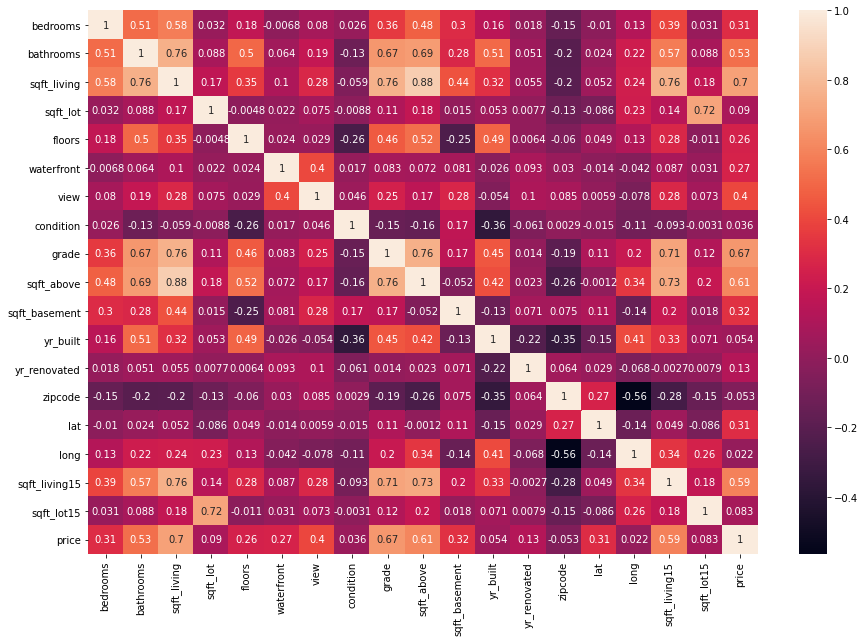

In [11]:
corr_matrix = data.corr(method='pearson')
fig, ax = plt.subplots(figsize=(15, 10))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()

#### There is a strong correlation between the taget variable - price, and variables sqft_living and grade.
#### Dropping some column and running models on raw data has shown, that almost all of the columns, despite of the correlations betweeen each other have impact on model's performace. In theory we would say that if some columns highly corelate with thwe target variable and with each other, than we can drop one correlating column and the model will perform the same or improve. But in practice, dropping this columns just decreases the model's performance.
#### After some trials, I have found that dropping certain columns does not improve the model, but does not harm either. So I decided to drop them and see what else I can do.

In [36]:
y = data['price']
data1 = data.drop(['price', 'sqft_lot', 'sqft_lot15', 'sqft_basement'], axis = 1, inplace = False)

In [37]:
data1

,bedrooms,bathrooms,sqft_living,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15
id,,,,,,,,,,,,,,,
7129300520,3,1.00,1180,1.0,0,0,3,7,1180,1955,0,98178,47.5112,-122.257,1340
6414100192,3,2.25,2570,2.0,0,0,3,7,2170,1951,1991,98125,47.7210,-122.319,1690
5631500400,2,1.00,770,1.0,0,0,3,6,770,1933,0,98028,47.7379,-122.233,2720
2487200875,4,3.00,1960,1.0,0,0,5,7,1050,1965,0,98136,47.5208,-122.393,1360
1954400510,3,2.00,1680,1.0,0,0,3,8,1680,1987,0,98074,47.6168,-122.045,1800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263000018,3,2.50,1530,3.0,0,0,3,8,1530,2009,0,98103,47.6993,-122.346,1530
6600060120,4,2.50,2310,2.0,0,0,3,8,2310,2014,0,98146,47.5107,-122.362,1830
1523300141,2,0.75,1020,2.0,0,0,3,7,1020,2009,0,98144,47.5944,-122.299,1020


In [38]:
data = data1.copy()

## Defining a function that differentiates between continuous and discrete variables. 

In [39]:
numcols = data.select_dtypes(np.number)
numcols_list = list(numcols.columns)
discrete_cols = []
continuous_cols = []
for col in numcols_list:
    item_counts = data[col].value_counts()
    print(col, ' : ', len(item_counts))
    if len(item_counts) > 120:
        continuous_cols.append(col)
    else:
        discrete_cols.append(col)
print(discrete_cols)
print(continuous_cols)

bedrooms  :  12
bathrooms  :  29
sqft_living  :  1034
floors  :  6
waterfront  :  2
view  :  5
condition  :  5
grade  :  11
sqft_above  :  942
yr_built  :  116
yr_renovated  :  70
zipcode  :  70
lat  :  5033
long  :  751
sqft_living15  :  777
['bedrooms', 'bathrooms', 'floors', 'waterfront', 'view', 'condition', 'grade', 'yr_built', 'yr_renovated', 'zipcode']
['sqft_living', 'sqft_above', 'lat', 'long', 'sqft_living15']


In [40]:
continuous = data[continuous_cols]
discrete = data[['bedrooms', 'bathrooms', 'floors', 'waterfront', 'view', 'condition', 'grade', 'yr_built', 'yr_renovated']]
categorical = 'zipcode'
display(continuous)
display(discrete)

,sqft_living,sqft_above,lat,long,sqft_living15
id,,,,,
7129300520,1180,1180,47.5112,-122.257,1340
6414100192,2570,2170,47.7210,-122.319,1690
5631500400,770,770,47.7379,-122.233,2720
2487200875,1960,1050,47.5208,-122.393,1360
1954400510,1680,1680,47.6168,-122.045,1800
...,...,...,...,...,...
263000018,1530,1530,47.6993,-122.346,1530
6600060120,2310,2310,47.5107,-122.362,1830
1523300141,1020,1020,47.5944,-122.299,1020


,bedrooms,bathrooms,floors,waterfront,view,condition,grade,yr_built,yr_renovated
id,,,,,,,,,
7129300520,3,1.00,1.0,0,0,3,7,1955,0
6414100192,3,2.25,2.0,0,0,3,7,1951,1991
5631500400,2,1.00,1.0,0,0,3,6,1933,0
2487200875,4,3.00,1.0,0,0,5,7,1965,0
1954400510,3,2.00,1.0,0,0,3,8,1987,0
...,...,...,...,...,...,...,...,...,...
263000018,3,2.50,3.0,0,0,3,8,2009,0
6600060120,4,2.50,2.0,0,0,3,8,2014,0
1523300141,2,0.75,2.0,0,0,3,7,2009,0


In [41]:
continuous['long'] = continuous['long'].abs()
continuous

<ipython-input-41-838ed76eeac3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  continuous['long'] = continuous['long'].abs()


,sqft_living,sqft_above,lat,long,sqft_living15
id,,,,,
7129300520,1180,1180,47.5112,122.257,1340
6414100192,2570,2170,47.7210,122.319,1690
5631500400,770,770,47.7379,122.233,2720
2487200875,1960,1050,47.5208,122.393,1360
1954400510,1680,1680,47.6168,122.045,1800
...,...,...,...,...,...
263000018,1530,1530,47.6993,122.346,1530
6600060120,2310,2310,47.5107,122.362,1830
1523300141,1020,1020,47.5944,122.299,1020


## Continuous numerical data vizualization and transformation

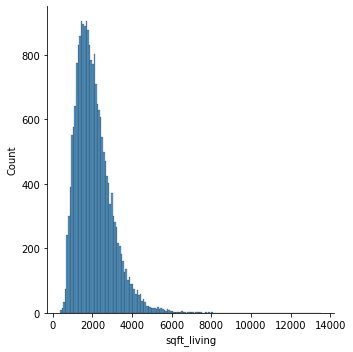

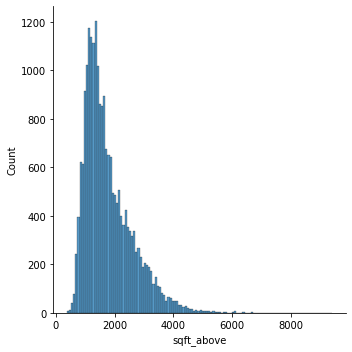

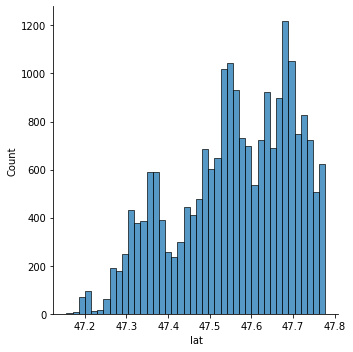

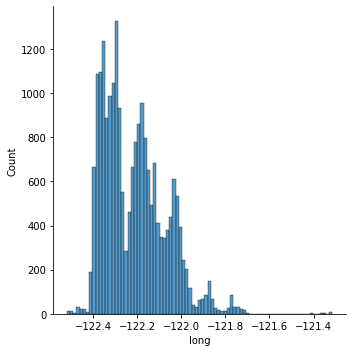

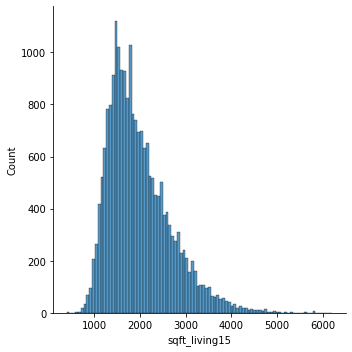

In [42]:
def num_plotter(df):
    numcolumns = df.select_dtypes(np.number)
    numcolumns_list = list(numcolumns.columns)
    for col in numcolumns_list:
        sns.displot(numcols, x = col)
        plt.show()

num_plotter(continuous)

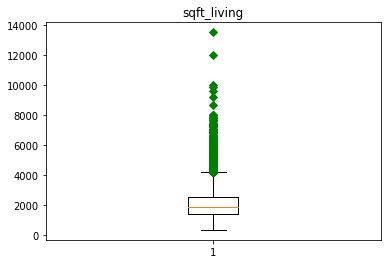

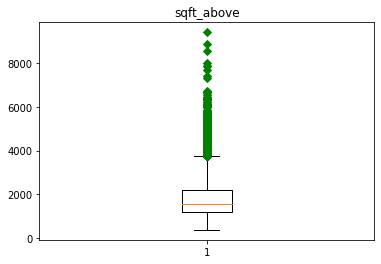

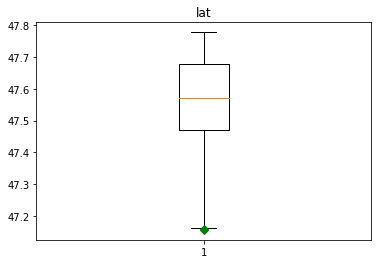

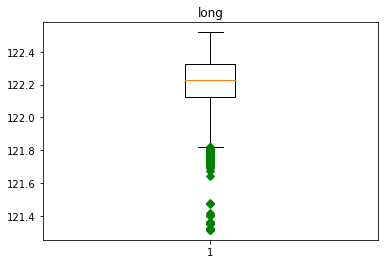

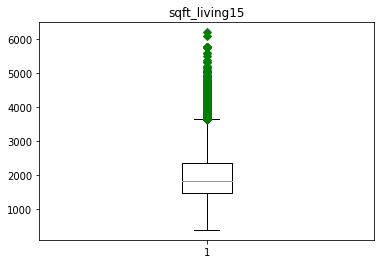

In [43]:
def get_boxplot(df):
    df_cols_list = list(df.columns)
    for col in df_cols_list:
        fig1, ax1 = plt.subplots()
        ax1.set_title(col)
        ax1.boxplot(df[col], 0, 'gD')
        plt.show()

get_boxplot(continuous)

## Transformation: Box-Cox

/home/annast/.local/lib/python3.8/site-packages/scipy/stats/morestats.py:906: RuntimeWarning: overflow encountered in power
  variance = np.var(data**lmb / lmb, axis=0)
/home/annast/.local/lib/python3.8/site-packages/numpy/core/_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/home/annast/.local/lib/python3.8/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/annast/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:2116: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/home/annast/.local/lib/python3.8/site-packages/numpy/core/_methods.py:216: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)


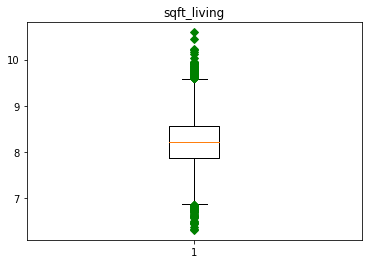

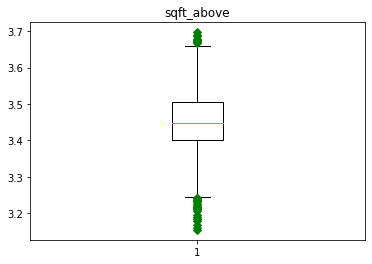

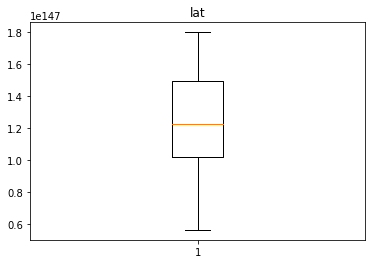

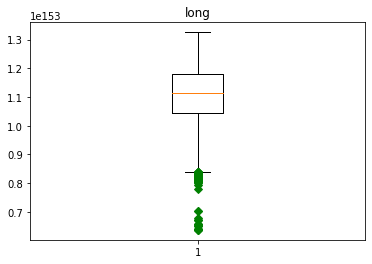

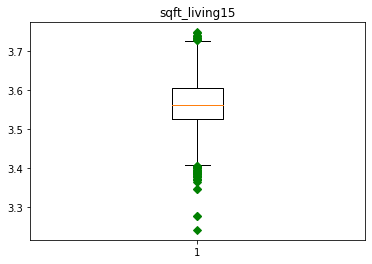

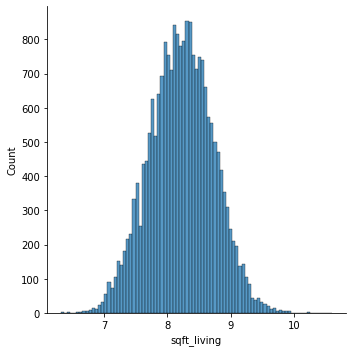

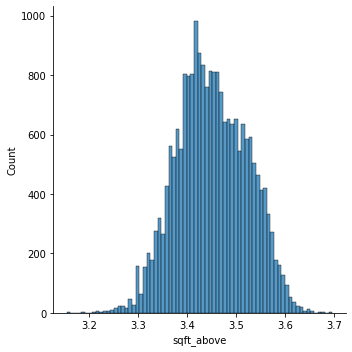

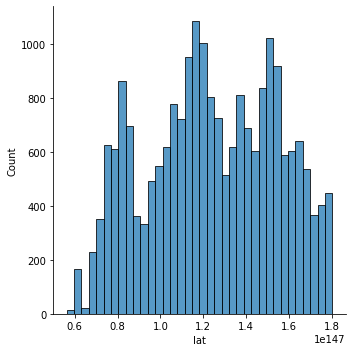

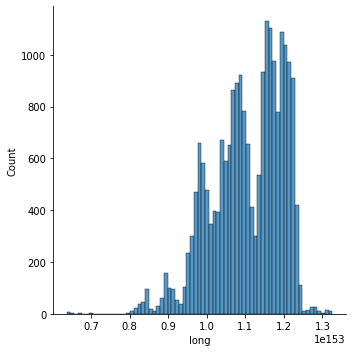

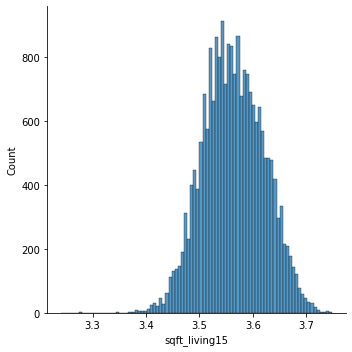

In [44]:
list_cols_cont = list(continuous.columns)
transformed_cont = continuous.copy()
for col in list_cols_cont:
    fitted_data, lmbda = stats.boxcox(transformed_cont[col])
    transformed_cont[col] = pd.DataFrame(fitted_data, index = continuous.index)

get_boxplot(transformed_cont)
numcolumns_list = list(transformed_cont.columns)
for col in numcolumns_list:
    sns.displot(transformed_cont, x = col)
    plt.show()

#### The distributions of continuous numerical variables after the transformation look more normal.

### Encoding the categorical data

In [45]:
dummies = pd.get_dummies(data['zipcode'], drop_first = True)

data_concat = pd.concat([transformed_cont,discrete, dummies], axis = 1)
data_concat

,sqft_living,sqft_above,lat,long,sqft_living15,bedrooms,bathrooms,floors,waterfront,view,...,98146,98148,98155,98166,98168,98177,98178,98188,98198,98199
id,,,,,,,,,,,,,,,,,,,,,
7129300520,7.658180,3.398681,1.096091e+147,1.130966e+153,3.504526,3,1.00,1.0,0,0,...,0,0,0,0,0,0,1,0,0,0
6414100192,8.576665,3.502039,1.621326e+147,1.174336e+153,3.547209,3,2.25,2.0,0,0,...,0,0,0,0,0,0,0,0,0,0
5631500400,7.161163,3.316683,1.673145e+147,1.114605e+153,3.627887,2,1.00,1.0,0,0,...,0,0,0,0,0,0,0,0,0,0
2487200875,8.255136,3.377090,1.115945e+147,1.228253e+153,3.507320,4,3.00,1.0,0,0,...,0,0,0,0,0,0,0,0,0,0
1954400510,8.073078,3.460455,1.335117e+147,9.942701e+152,3.558416,3,2.00,1.0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263000018,7.962922,3.444609,1.557109e+147,1.193733e+153,3.529195,3,2.50,3.0,0,0,...,0,0,0,0,0,0,0,0,0,0
6600060120,8.449871,3.511814,1.095067e+147,1.205375e+153,3.561327,4,2.50,2.0,0,0,...,1,0,0,0,0,0,0,0,0,0
1523300141,7.487998,3.371633,1.280449e+147,1.160170e+153,3.451315,2,0.75,2.0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Scaling all the data (continuous, discrete and encoded categoricals)

In [46]:
from sklearn.preprocessing import StandardScaler
scaled_features = StandardScaler().fit_transform(data_concat.values)
transformed = pd.DataFrame(scaled_features, index = data_concat.index, columns = data_concat.columns)
transformed

,sqft_living,sqft_above,lat,long,sqft_living15,bedrooms,bathrooms,floors,waterfront,view,...,98146,98148,98155,98166,98168,98177,98178,98188,98198,98199
id,,,,,,,,,,,,,,,,,,,,,
7129300520,-1.124420,-0.737381,-0.476117,0.277071,-1.043484,-0.402903,-1.451073,-0.915552,-0.087205,-0.305715,...,-0.116256,-0.051442,-0.145212,-0.109091,-0.112306,-0.109308,9.023929,-0.079606,-0.114608,-0.122052
6414100192,0.707178,0.705707,1.266485,0.752443,-0.294269,-0.402903,0.174486,0.937431,-0.087205,-0.305715,...,-0.116256,-0.051442,-0.145212,-0.109091,-0.112306,-0.109308,-0.110816,-0.079606,-0.114608,-0.122052
5631500400,-2.115547,-1.882247,1.438410,0.097742,1.121899,-1.482493,-1.451073,-0.915552,-0.087205,-0.305715,...,-0.116256,-0.051442,-0.145212,-0.109091,-0.112306,-0.109308,-0.110816,-0.079606,-0.114608,-0.122052
2487200875,0.066001,-1.038843,-0.410245,1.343409,-0.994441,0.676687,1.149821,-0.915552,-0.087205,-0.305715,...,-0.116256,-0.051442,-0.145212,-0.109091,-0.112306,-0.109308,-0.110816,-0.079606,-0.114608,-0.122052
1954400510,-0.297051,0.125108,0.316914,-1.221218,-0.097539,-0.402903,-0.150626,-0.915552,-0.087205,-0.305715,...,-0.116256,-0.051442,-0.145212,-0.109091,-0.112306,-0.109308,-0.110816,-0.079606,-0.114608,-0.122052
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263000018,-0.516717,-0.096139,1.053431,0.965040,-0.610463,-0.402903,0.499597,2.790414,-0.087205,-0.305715,...,-0.116256,-0.051442,-0.145212,-0.109091,-0.112306,-0.109308,-0.110816,-0.079606,-0.114608,-0.122052
6600060120,0.454332,0.842188,-0.479516,1.092653,-0.046444,0.676687,0.499597,0.937431,-0.087205,-0.305715,...,8.601720,-0.051442,-0.145212,-0.109091,-0.112306,-0.109308,-0.110816,-0.079606,-0.114608,-0.122052
1523300141,-1.463788,-1.115030,0.135538,0.597165,-1.977502,-1.482493,-1.776184,0.937431,-0.087205,-0.305715,...,-0.116256,-0.051442,-0.145212,-0.109091,-0.112306,-0.109308,-0.110816,-0.079606,-0.114608,-0.122052


In [47]:
X = transformed
X

,sqft_living,sqft_above,lat,long,sqft_living15,bedrooms,bathrooms,floors,waterfront,view,...,98146,98148,98155,98166,98168,98177,98178,98188,98198,98199
id,,,,,,,,,,,,,,,,,,,,,
7129300520,-1.124420,-0.737381,-0.476117,0.277071,-1.043484,-0.402903,-1.451073,-0.915552,-0.087205,-0.305715,...,-0.116256,-0.051442,-0.145212,-0.109091,-0.112306,-0.109308,9.023929,-0.079606,-0.114608,-0.122052
6414100192,0.707178,0.705707,1.266485,0.752443,-0.294269,-0.402903,0.174486,0.937431,-0.087205,-0.305715,...,-0.116256,-0.051442,-0.145212,-0.109091,-0.112306,-0.109308,-0.110816,-0.079606,-0.114608,-0.122052
5631500400,-2.115547,-1.882247,1.438410,0.097742,1.121899,-1.482493,-1.451073,-0.915552,-0.087205,-0.305715,...,-0.116256,-0.051442,-0.145212,-0.109091,-0.112306,-0.109308,-0.110816,-0.079606,-0.114608,-0.122052
2487200875,0.066001,-1.038843,-0.410245,1.343409,-0.994441,0.676687,1.149821,-0.915552,-0.087205,-0.305715,...,-0.116256,-0.051442,-0.145212,-0.109091,-0.112306,-0.109308,-0.110816,-0.079606,-0.114608,-0.122052
1954400510,-0.297051,0.125108,0.316914,-1.221218,-0.097539,-0.402903,-0.150626,-0.915552,-0.087205,-0.305715,...,-0.116256,-0.051442,-0.145212,-0.109091,-0.112306,-0.109308,-0.110816,-0.079606,-0.114608,-0.122052
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263000018,-0.516717,-0.096139,1.053431,0.965040,-0.610463,-0.402903,0.499597,2.790414,-0.087205,-0.305715,...,-0.116256,-0.051442,-0.145212,-0.109091,-0.112306,-0.109308,-0.110816,-0.079606,-0.114608,-0.122052
6600060120,0.454332,0.842188,-0.479516,1.092653,-0.046444,0.676687,0.499597,0.937431,-0.087205,-0.305715,...,8.601720,-0.051442,-0.145212,-0.109091,-0.112306,-0.109308,-0.110816,-0.079606,-0.114608,-0.122052
1523300141,-1.463788,-1.115030,0.135538,0.597165,-1.977502,-1.482493,-1.776184,0.937431,-0.087205,-0.305715,...,-0.116256,-0.051442,-0.145212,-0.109091,-0.112306,-0.109308,-0.110816,-0.079606,-0.114608,-0.122052


## Let's see the distribution of the target variable - price.

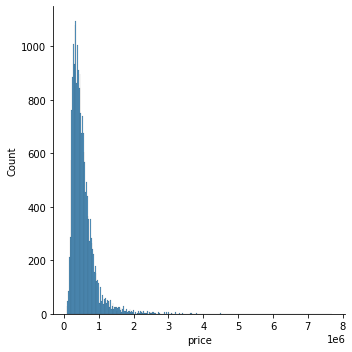

In [48]:
sns.displot(y)
plt.show()

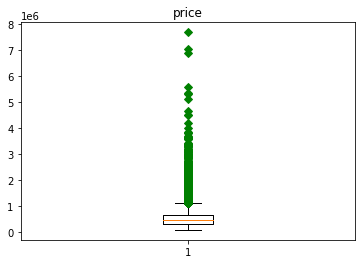

In [50]:
fig1, ax1 = plt.subplots()
ax1.set_title('price')
ax1.boxplot(y, 0, 'gD')
plt.show()

#### The distribution is very skewed and we can see that the variable has many outliers. So, we need to deal with this. Deleting the outliers is not an option, because the model will not be able to predict high prices of the houses. 
#### Let's do the log transformation of the column, this will help to make the distribution more normal.
### After training the model, we will reverse the transformation by putting test set and predictions back to the exponential form.

## Log transformation of the target variable

In [51]:
y_log = np.log(y) 

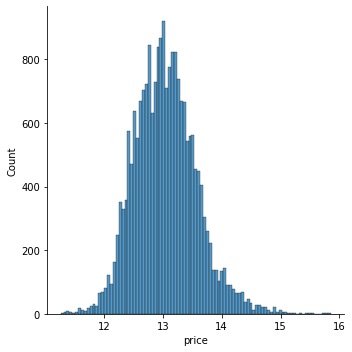

In [52]:
sns.displot(y_log)
plt.show()

## Finally, let's train our different models with the transformed data and see how this affected the performance.

### I will mainly concentrate on XGBoost model, because it was showing the best performance. But I will also check the performance of the linear model and the KNN model.
#### Also, in other notebooks, I have been doing some hyperparamether tuning in order to decrease the mean absolute error, so I will  add some parameters in my model here.

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=20)

In [61]:
model = xgb.XGBRegressor(eta = 0.111, eval_metric = 'rmse')
model.fit(X_train, y_train)
predictions = model.predict(X_test)

y_test_exp = np.exp(y_test)
predictions_exp = np.exp(predictions)

def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return (np.mean(np.abs((actual - pred) / actual)) * 100) , (np.abs((actual - pred) / actual)*100)

MAE = mean_absolute_error(predictions_exp, y_test_exp)
R2 = r2_score(y_test_exp,predictions_exp)
MSE = mean_squared_error(y_test_exp ,predictions_exp)
RMSE = np.sqrt(MSE)
MAPE, list_errors = mape(y_test_exp, predictions_exp )


print("results for XGBRegression model")
print()
print("The mean absolute error of the model in the test set is: %6.2f" % (MAE))
print()
print("The mean squared error of the model in the test set is: %6.2f" % (MSE))
print()
print("The root mean squared error of the model in the test set is: %6.2f" % (RMSE))
print()
print("The R2 of the model in the test set is: %4.2f" % (R2))
print()
print("The mean absolute percentage error of the model in the test set is: %4.2f" % (MAPE))

results for XGBRegression model

The mean absolute error of the model in the test set is: 67865.55

The mean squared error of the model in the test set is: 16917274993.39

The root mean squared error of the model in the test set is: 130066.43

The R2 of the model in the test set is: 0.88

The mean absolute percentage error of the model in the test set is: 12.48


#### Vizualizing the performace of the model (errors and relation between test set and presictions)

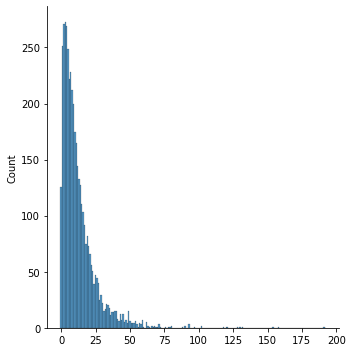

In [62]:
sns.displot(list_errors, binwidth=10, bins=300, discrete=True)

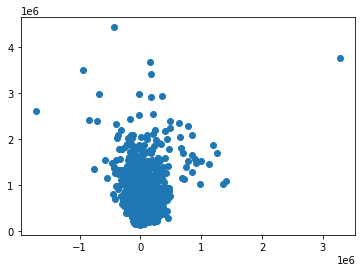

In [63]:
residuals = y_test_exp - predictions_exp
plt.scatter(residuals, predictions_exp)
plt.show()

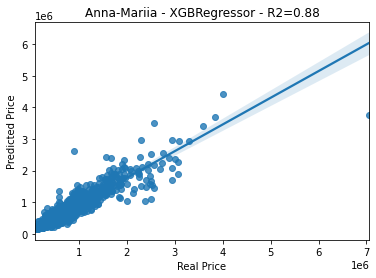

In [64]:
sns.regplot(x=y_test_exp, y=predictions_exp)
plt.title('Anna-Mariia - XGBRegressor - R2=0.88')
plt.xlabel('Real Price')
plt.ylabel('Predicted Price')
plt.savefig('plot.png', dpi=300, bbox_inches='tight')
plt.show()

### Building the other models to compare the error metrics.

results for actual linear model

The mean absolute error of the model in the test set is: 73965.82

The mean squared error of the model in the test set is: 17095695591.81

The root mean squared error of the model in the test set is: 130750.51

The R2 of the model in the test set is: 0.87

The mean absolute percentage error of the model in the test set is: 13.61
------------------------------------------------------
results for actual knn, k = 2

The mean absolute error of the model in the test set is: 89312.81

The mean squared error of the model in the test set is: 31705697689.56

The root mean squared error of the model in the test set is: 178060.94

The R2 of the model in the test set is: 0.77

The mean absolute percentage error of the model in the test set is: 15.76
------------------------------------------------------
results for actual knn, k = 3

The mean absolute error of the model in the test set is: 84016.13

The mean squared error of the model in the test set is: 2833962455

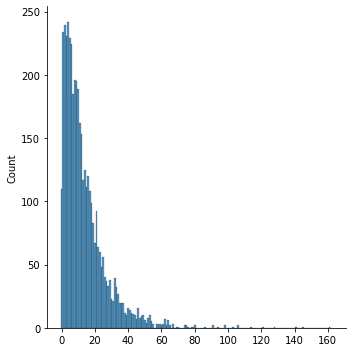

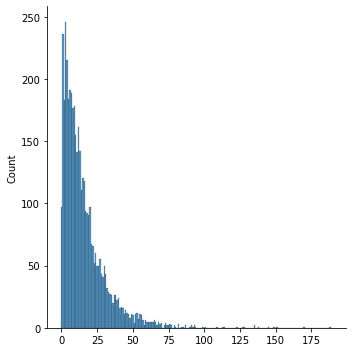

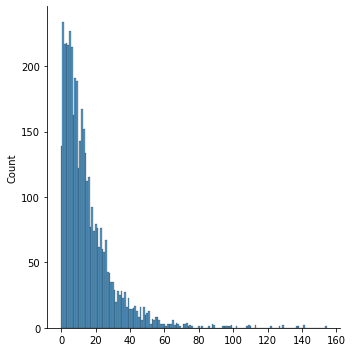

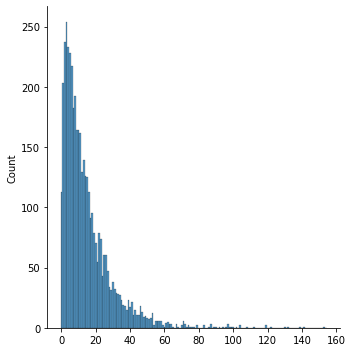

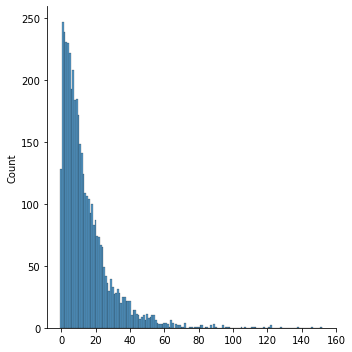

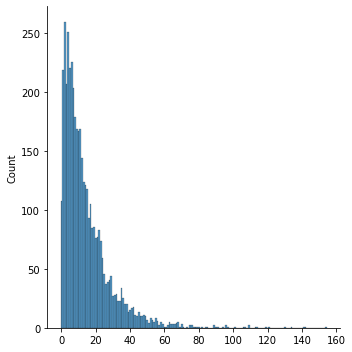

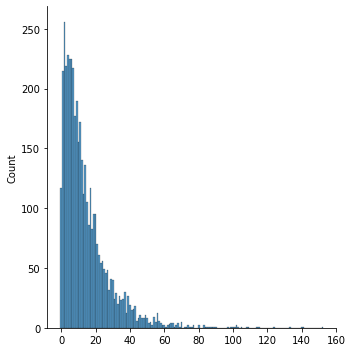

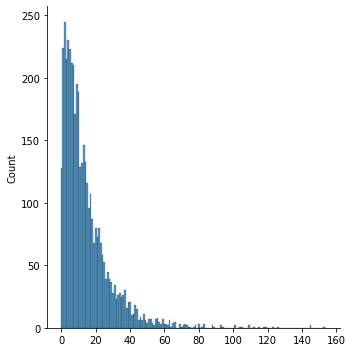

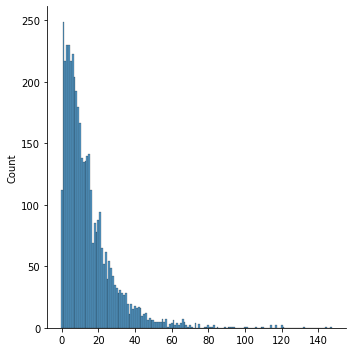

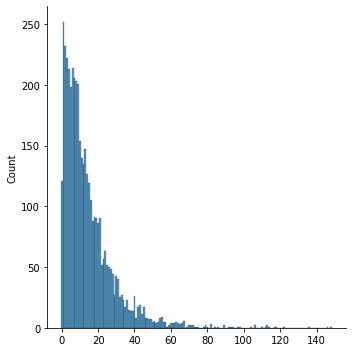

In [65]:
def show_metrics(name, predictions, actuals):
    MAE = mean_absolute_error(actuals, predictions)
    MSE = mean_squared_error(actuals ,predictions)
    RMSE = np.sqrt(MSE)
    R2 = r2_score(actuals, predictions)
    MAPE, my_list_of_relative_errors = mape(actuals, predictions )

    print("results for", name)
    print()
    print("The mean absolute error of the model in the test set is: %6.2f" % (MAE))
    print()
    print("The mean squared error of the model in the test set is: %6.2f" % (MSE))
    print()
    print("The root mean squared error of the model in the test set is: %6.2f" % (RMSE))
    print()
    print("The R2 of the model in the test set is: %4.2f" % (R2))
    print()
    print("The mean absolute percentage error of the model in the test set is: %4.2f" % (MAPE))
    
    sns.displot(my_list_of_relative_errors, binwidth=10, bins=300, discrete=True)
    print("------------------------------------------------------")

def lin_model_maker(X_train, y_train, X_test):
    lm = linear_model.LinearRegression()
    lm_model = lm.fit(X_train,y_train)
    lm_predictions = lm_model.predict(X_test)
    return lm_predictions

def knn_model_maker(X_train, y_train, X_test, K):
    knn_model = KNeighborsRegressor(n_neighbors=K) # The keyword "n_neighbors" is what sets the K.
    knn_model.fit(X_train, y_train)
    knn_predictions = knn_model.predict(X_test)
    return knn_predictions

def knn_model_creator(K):
    return lambda X_train, y_train, X_test : knn_model_maker(X_train, y_train, X_test, K)

linear = lin_model_maker

model_dict = {linear:"linear model"}

for i in range(2, 11):
    model_dict[knn_model_creator(i)] = str("knn, k = %d" % (i))

for m, name in model_dict.items():
    log_predictions = m(X_train, y_train, X_test)

    actuals = np.exp(y_test)
    predictions = np.exp(log_predictions)
    show_metrics("actual "+name, predictions, actuals)

    


#### Looking st theese other models, we see that despite the R2 of the Linear model is not so different, still the mean absolute percentage error of the model is worse, so it is worse in predicting the actual values of price.

# Conclusions

### Eventually, although I got some improvements in the performance of the model, every aproach applied by me failed to adress the problem of outliers in the model. We will discuss the possible ways of dealing wiwth this problem at the presentation.